In [3]:
# Initialize Otter
import otter
grader = otter.Notebook("lab07.ipynb")

# Lab 7: Estimating Causal Effects via Instrumental Variables
Welcome to the seventh DS102 lab! 

The goals of this lab is to implement and get better understanding of Instrumental Variables discussed in Lecture. IV provide us with a way to estimate a causal effect even when the treatment itself is not randomly assigned.

The code you need to write is indicated by `...`

## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Submission
See the [Gradescope Submission Guidelines](https://edstem.org/us/courses/33922/discussion/2419862) for details on how to submit your lab.

**For full credit, this assignment should be completed and submitted before Wednesday, March 22nd, 2023 at 11:59 PM PDT.**

## Collaborators
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import itertools
from ipywidgets import interact, interactive

import hashlib

sns.set(style="dark")
plt.style.use("ggplot")
%matplotlib inline

# Instrumental Variables Background
Suppose that we measure $Z$, the number of books a student read in the last year, and we are interested in determing how $Z$ affects an observed target outcome $Y$, the student's SAT score. The effect we are interested in is **causal** because we want to know how $Y$ changes if all randomness other than $Z$ remains fixed, and only $Z$ changes. We will refer to $Z$ as the "treatment". In general, $Z$ might be multi-dimensional, however for the purpose of this exercise we take $Z \in\mathbb{R}$.

Suppose there's also a confounder $X$, which is the income of the student's family. We don't observe $X$, but it affects both the number of books the student reads (wealthier families may have more access to books) and the student's SAT score (wealthier students may have more access to SAT tutoring).

We assume that the outcome is generated as a linear function of the confounder $X$ and treatment $Z$, with additive noise $\epsilon$:
$$Y = \beta_1 Z + \beta_2 X + \epsilon.$$

The goal is to estimate $\beta_1$, the true causal effect of the number of books a student reads on their SAT score.

### Danger of bias
As we saw in the [instrumental variable lecture note](http://data102.datahub.berkeley.edu/hub/user-redirect/git-sync?repo=https://github.com/ds-102/sp23&subPath=lecture/lecture17/05_instrumental_variables.ipynb), if the confounder $X$ is highly correlated with $Z$, performing ordinary least squares (OLS) on the observed data $Z$, $Y$ can lead to very biased results. Because wealthier families may have access to more books, without observing $X$ we cannot tell if correlation between $Z$ and $Y$ is due to a causal effect of reading books or is due to the higher average family income.

### Instrumental variables (IVs) and two-stage least squares (2SLS)

One way to get around this issue is by using **instrumental variables (IVs)**. A valid instrument $W$ is a variable which is independent of the confounder $X$, and affects $Y$ only through $Z$. For example, we can create such an instrument $W$ by employing *encouragement design*, where we randomly assign students to "readathons" of different durations. See the figure below for a causal diagram:

<img src="causal_diagram.png" width="400">

Using the instrumental variable $W$, we can estimate $\beta_1$ by first "guessing" $Z$ from $W$ using ordinary least squares (OLS) (denoted $\hat Z$), and then regressing $Y$ onto $\hat Z$ (instead of $Z$) using OLS as well. This procedure is known as **two-stage least squares (2SLS)**. 

In this lab, we will observe the bias that can occur when naively performing OLS on the observed data $Z, Y$, and also how employing 2SLS can achieve a better estimate of $\beta_1$.

# Model setup

Suppose that we have historical data from $n=10,000$ different students. Suppose we observe the following variables: 

$Z^{(i)} =$ number of books the student read in the last year, 

$W^{(i)} = $ duration of the "readathon" at the student's school.

$Y^{(i)} = $ the student's SAT score. 

Suppose that the student's family income $X^{(i)}$ affects both $Z^{(i)}$ and $Y^{(i)}$, but is **not observed**.

## Data Generation

The student's SAT score is linear in the number of books the student read and the student's family income:
$$Y^{(i)} = \beta_1 Z^{(i)} + \beta_2 X^{(i)} + \epsilon^{(i)}.$$ 

The number of books a student reads is linear in the duration of the readathon and the student's family income:
$$Z^{(i)} = \gamma_1 W^{(i)} + \gamma_2 X^{(i)} + \epsilon'^{(i)},$$

### The true model was generated in the following manner:
 - Sample $W^{(i)}\sim N(20,5)$    $\ \longleftarrow\ $   *Duration of Readathon for student* $i$ 
 - Sample $X^{(i)} \sim \text{Normal}(50, 10)$   $\ \longleftarrow\ $   *Income in tens of thousands (10,000) dollars for the family of student* $i$ **(unobserved variable)**
 - Generate $Z^{(i)}$ by setting $\gamma_1 = \gamma_2 =1$ and sampling a noise $\epsilon'^{(i)}\sim N(0,5)$   $\ \longleftarrow\ $  *Number of books read by student* $i$
 - Generate $Y^{(i)}$ by setting $\beta_1 = 5$, $\beta_2 = 12$  and sampling a noise $\epsilon^{(i)}\sim N(0,10)$ $\ \longleftarrow\ $  *SAT score for student* $i$.
 
**Note: The data in this lab are not observed in real life. They are instead synthetic data generated according to the procedure described above.**

## Load the data
Run the cells below to load and plot the data.

In [5]:
# Do not modify: Just run this to load the data
student_data = pd.read_csv("SAT_data.csv")
student_data.head()

,NumBooks,Income,SAT,ReadathonDuration
0,54.0,45.473122,799.0,16.0
1,71.0,53.064868,991.0,15.0
2,79.0,52.522466,1017.0,19.0
3,92.0,61.322441,1197.0,23.0
4,65.0,53.453239,982.0,12.0


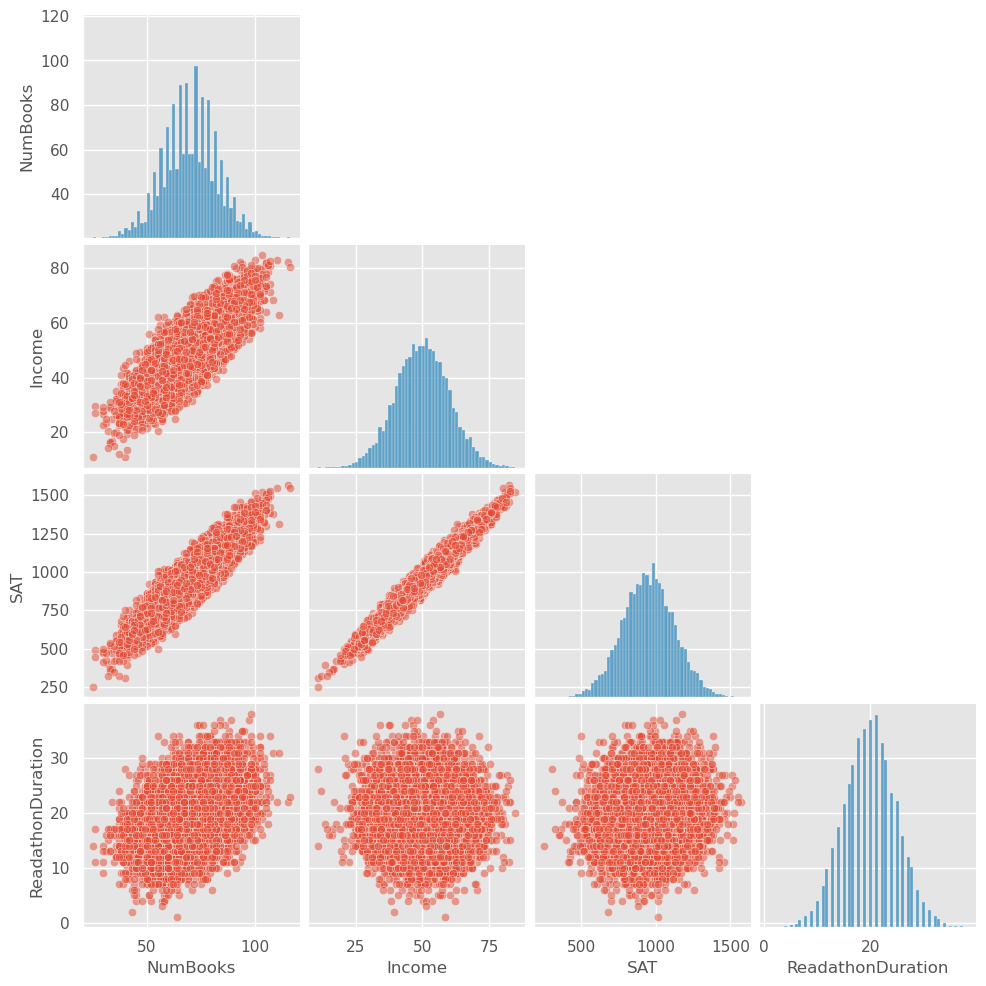

In [6]:
# make a pairplot illustrating the pairwise correlations between different columns in the dataset
fig = sns.pairplot(student_data,  plot_kws=dict(marker="o", alpha = 0.5))
for i, j in zip(*np.triu_indices_from(fig.axes, 1)):
    fig.axes[i, j].set_visible(False)
plt.show()

In the plot above on the main diagonal we have the histograms of each variable, and on the off-diagonals we have scatter plots illustrating the corelations between pair of variables. 

# Question 1: Understanding the Model

## 1.a) Correlations between variables

<!-- BEGIN QUESTION -->

#### 1.a.i) Just by inspecting the pairplot above rank in order from most correlated to least correlated the following pairwise relationships: 
#### Z &  X, Z &  Y, Z & W, X & Y, X & W, Y & W

X & Y, Z & Y, Z & X, Z & W, Y & W, X & W

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### 1.a.ii) Which of the above pairs appear to be independent?

X & W

<!-- END QUESTION -->

## 1.b) Understanding the marginal impacts

Inspect the Data Generation section above, and answer the following questions. 

<!-- BEGIN QUESTION -->

#### 1.b.i) What is the true causal effect of an extra book read on the SAT score (i.e. if you hold everything else constant and you read one more book by how much will the SAT score change)?

Per extra book read increases 5 SAT score.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### 1.b.ii) What is the true causal effect of increasing income by \$10000 on the SAT score?

Income increases by 120000

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### 1.b.iii) What is the true causal effect of an extra readathon day on the number of books read?

Increases books read by 1

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### 1.b.iv) What is the true causal effect of increaing income by \$10000 on the number of books read?

Increases books read by 10000

<!-- END QUESTION -->

## 1.c) When are readathons a valid instrument?

This lab uses synthetic data on reading instead of real data. Let's think about the conditions on readathons we would need for $W$ to be a valid instrument.

<!-- BEGIN QUESTION -->

#### 1.c.i) What must be true about the relationship between readathons and income for $W$ to be a valid instrument? Give an example of how this might be violated.

Readathons and income must be independent. If readathon has fees to enter, low-income students are less likely to participate compared to high-income students.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### 1.c.ii) What must be true about the relationship between readathons and SAT score for $W$ to be a valid instrument? Give an example of how this might be violated?

Readathons and SAT score also must be indepedent. If the students that participates readathons are studious and want to succeed academically, they are also likely to participate in SAT tutor to increase their score.

<!-- END QUESTION -->

## Ordinary Least Squares
If we had access to income data $X$, then we could estimate directely $\beta_1$, $\beta_2$, $\gamma_1$, $\gamma_2$ from the data by setting up a linear regression problem and finding Ordinary Least Squares estimator. 

$$\hat\beta_1, \hat\beta_2 = \arg\min_{\beta_1, \beta_2}\Vert Y - \beta_1Z - \beta_2X \Vert_2^2$$
$$\hat\gamma_1, \hat\gamma_2 = \arg\min_{\gamma_1, \gamma_2}\Vert Z - \gamma_1W - \gamma_2X \Vert_2^2$$

To find OLS estimators we will use [`sm.OLS`](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html?highlight=ols) from `statsmodels.api`.

In [7]:
# No TODOs here: Just examine the code
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

In [8]:
# Computing the OLS estimators for gamma_1 and gamma_2
gammas_model = fit_OLS_model(student_data, 'NumBooks', ['ReadathonDuration', 'Income'])
print(gammas_model.summary())

                                 OLS Regression Results                                
Dep. Variable:               NumBooks   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          9.849e+05
Date:                Wed, 22 Mar 2023   Prob (F-statistic):                        0.00
Time:                        21:08:32   Log-Likelihood:                         -30390.
No. Observations:               10000   AIC:                                  6.078e+04
Df Residuals:                    9998   BIC:                                  6.080e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [9]:
# Print the fitted_estimators
gammas = gammas_model.params
print("The estimated causal effect on number of books read of an additional Readathon day is {:.2f}".format(gammas[0]))
print("The estimated causal effect on number of books read of an additional $10000 is {:.2f}".format(gammas[1]))
# The numbers you get should be very close to you answer in 1.b

The estimated causal effect on number of books read of an additional Readathon day is 1.00
The estimated causal effect on number of books read of an additional $10000 is 1.00


## 1.d) Estimate causal effect of `NumBooks` and `Income` on the SAT Score

Fill in the code below (similar as above) to estimate the causal effect of `NumBooks` and `Income` on the SAT Scores. 

In [20]:
# Compute OLS estimators for beta_1 and beta_2
betas_model = fit_OLS_model(student_data, 'SAT', ['NumBooks', 'Income'])
print(betas_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    SAT   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.546e+07
Date:                Wed, 22 Mar 2023   Prob (F-statistic):                        0.00
Time:                        21:16:13   Log-Likelihood:                         -37348.
No. Observations:               10000   AIC:                                  7.470e+04
Df Residuals:                    9998   BIC:                                  7.471e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [21]:
grader.check("q1d")

q1d results: All test cases passed!

In [22]:
# Print the fitted_estimators
betas = betas_model.params
print("The estimated causal effect on SAT score of an additional book read is {:.2f}".format(betas['NumBooks']))
print("The estimated causal effect on SAT score of an additional $10000 is {:.2f}".format(betas['Income']))
# The numbers you get should be very close to you answer in 1.b

The estimated causal effect on SAT score of an additional book read is 4.98
The estimated causal effect on SAT score of an additional $10000 is 12.03


## Summing up Question 1

In Question 1 we saw how we can estimate all causal relationships if we have access to the income variable. But what if we **do not observe Income**?

**Our Next Goal**: estimate $\beta_1$, the true causal effect of the number of books a student reads on their SAT score *without access* to the Income variable.

# 2. Naive OLS: OLS on the observed variables $Z$, $Y$.
The confounding variable $X$ (family income) is unfortunately unobserved. We will start by somewhat "naively" attempting to estimate the causal effect $\beta_1$ by using plain linear regression (OLS) on the observed variables $Z$ and $Y$. This time we will include an intercept term:

$$\hat\beta_1, \hat c = \arg\min_{\beta_1, c} \Vert Y - \beta_1Z - c \Vert^2_2$$

## 2.a) Fit Naive OLS
Fill in the code below to fit the OLS model described above.

In [36]:
# Fit OLS parameters to predict Y from Z.
beta_naive_model = fit_OLS_model(student_data, 'SAT', 'NumBooks', 'ReadathonDuration')
print(beta_naive_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SAT   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                 5.117e+04
Date:                Wed, 22 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:29:39   Log-Likelihood:                -56726.
No. Observations:               10000   AIC:                         1.135e+05
Df Residuals:                    9998   BIC:                         1.135e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.8488      4.074     10.518      0.0

In [37]:
grader.check("q2a")

q2a results: All test cases passed!

In [38]:
print("The Naive OLS estimate of beta_1 is {:.2f}, while the true beta_1 is {}".format(beta_naive_model.params[1], 5))

The Naive OLS estimate of beta_1 is 12.96, while the true beta_1 is 5


<!-- BEGIN QUESTION -->

## 2.b) Does the Naive approach overestimate or under estimate the value of reading books?

*Hint: Answer this question by comparing the naive estimate and the true value of $\beta_1$*

overestimates; 12.96 vs 5

<!-- END QUESTION -->

# 3. Instrumental variables and 2SLS

To eliminate the bias, we turn to instrumental variables. In the first stage, we "predict" the number of books a student read from whether or not they had a readathon, $W$, producing an estimate $\hat{Z}$. Then, in the second stage, we regress the SAT score $Y$ onto the predicted number of books read $\hat{Z}$.

## Stage 1: Predict treatment variable $\hat{Z}$ from instrumental variable $W$

In [39]:
# No TODOs here, just run this call and understand what this function is doing.
def compute_OLS_predictions(input_array, input_params):
    """Calculates OLS predictions from fitted OLS parameters, input_params.
    
    Args:
      input_array: numpy array with n entries, where each entry corresponds with a feature value for a given student.
      input_params: numpy array with 2 entries, where the entries are [intercept, beta_hat]. 
        The intercept is a constant term, so the final OLS predictions should be 
        predictions = intercept + beta_hat*input_array.

    Returns:
      numpy array with n entries containing predictions from input_array.
    """
    predictions = input_params[0] + input_params[1] * input_array 
    return predictions

## 3.a) Predicting $\hat{Z}$

#### 3.a.i) Complete the code below to fit an OLS model that predicts $\hat{Z}$ (estimated number of books read) using $W$ (whether they had a readathon).

$$\hat\gamma_1, \hat c = \arg\min_{\gamma_1, c} \Vert Z - \gamma_1W - c\Vert_2^2$$

In [43]:
# Fit OLS parameters to predict Z from W
gamma1_model = fit_OLS_model(student_data, 'NumBooks', 'ReadathonDuration', 'ReadathonDuration')
print(gamma1_model.summary())

                            OLS Regression Results                            
Dep. Variable:               NumBooks   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     1927.
Date:                Wed, 22 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:43:50   Log-Likelihood:                -38391.
No. Observations:               10000   AIC:                         7.679e+04
Df Residuals:                    9998   BIC:                         7.680e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                50.1628      0.46

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [44]:
grader.check("q3a_i")

q3a_i results: All test cases passed!

In [45]:
print("The OLS estimate of gamma_1 is {:.3f}, while the true gamma_1 is {}".format(gamma1_model.params[1], 1))

The OLS estimate of gamma_1 is 0.996, while the true gamma_1 is 1


<!-- BEGIN QUESTION -->

#### 3.a.ii) We observe that the estimate of $\gamma_1$ above is very close to the true value, even though we don't make use of the `Income` variable. How can you explain this?
*Hint: Think about independence, and how the relationship between X and Z might be affected by the relationship between W and Z.*

This is because income and readathon are independent therefore income is not required for us to predict numbooks. Just having readathon will give us good prediction to true value.

<!-- END QUESTION -->

#### 3.a.iii) (OPTIONAL - NOT GRADED) 

We just saw that the estimate for $\gamma_1$ is unbiased for the true value with only $W$. Back in Question 1 we also did a regression to get $\gamma_1$ where we included both $W$ and $X$ as regressors. What additional benefit does including $X$ give for estimating $\gamma_1$?

_Type your answer here, replacing this text._

### Now we can use the OLS model above to create $\hat Z$ predictions

In [46]:
# Compute predictions for number of books read
intercept_OLS = gamma1_model.params[0]
gamma1_OLS = gamma1_model.params[1]
Z_hat = intercept_OLS + gamma1_OLS*student_data['ReadathonDuration']

# Add the predictions to the student_data dataframe
student_data['PredictedNumBooks'] = Z_hat
student_data.head()

,NumBooks,Income,SAT,ReadathonDuration,PredictedNumBooks
0,54.0,45.473122,799.0,16.0,66.104173
1,71.0,53.064868,991.0,15.0,65.107836
2,79.0,52.522466,1017.0,19.0,69.093186
3,92.0,61.322441,1197.0,23.0,73.078536
4,65.0,53.453239,982.0,12.0,62.118823


## Stage 2: Estimate target $Y$ from predicted treatment variable $\hat{X}_1$

## 3.b) Fit OLS parameters to predict $Y$ from the predicted $\hat Z$
$$\hat \beta_1, \hat c = \arg\min_{\beta_1, c}\Vert Y-\beta_1\hat Z - c\Vert_2^2$$

In [47]:
# Fit OLS parameters to predict Y from the predicted Z_hat.
beta1_model = fit_OLS_model(student_data, 'SAT', 'PredictedNumBooks', 'ReadathonDuration')
print(beta1_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SAT   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     191.8
Date:                Wed, 22 Mar 2023   Prob (F-statistic):           3.24e-43
Time:                        21:50:33   Log-Likelihood:                -65687.
No. Observations:               10000   AIC:                         1.314e+05
Df Residuals:                    9998   BIC:                         1.314e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               611.8673     24.51

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [48]:
grader.check("q3b")

q3b results: All test cases passed!

In [49]:
print("The 2SLS estimate of beta_1 is {:.3f}, while the true value is {}".format(beta1_model.params[1], 5))

The 2SLS estimate of beta_1 is 4.835, while the true value is 5


## 3.c) Conceptual Questions

<!-- BEGIN QUESTION -->

#### 3.c.i) Which technique produced a better estimate of $\beta_1$, naive OLS or 2SLS?

2SLS

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### 3.c.ii) Qualitatively, how would you describe the predictions $\hat Z$? How do they compare to the original $Z$? What sources of variation do they remove?

*Hint: If it helps to see the predicted and original values, you can look at the dataframe `student_data` or look at the snippet above printed out right before Stage 2.*

prediction $\hat Z$ is close to linear function for readathon and is not a good comparsion to the original $Z$ The two does not look identical and SAT is removed as source of variation.

<!-- END QUESTION -->



In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread('cute_animal_dot_jpg.jpg')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
print("Yay, you've made it to the end of Lab 7!")
plt.show()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)